In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import scipy

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score, hamming_loss, confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


# from sklearnex import patch_sklearn
# patch_sklearn()

In [28]:
# Read in the pickle file

with open('../saved_file/after_eda.pickle', 'rb') as f:
    df_train = pickle.load(f)

df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,word_count,unique_word_count,upper_case_word_count,stop_word_count,punctuation_count,title_word_count,sentence_count,percent_unique_word_count,percent_upper_case_word_count,percent_punctuation_count,cleaned_comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,43,41,2,20,10,11,5,95.348837,4.651163,23.255814,explanation why the edit make under my usernam...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,17,17,1,3,12,3,4,100.000000,5.882353,70.588235,d aww he match this background colour i be see...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,42,39,0,21,6,2,4,92.857143,0.000000,14.285714,hey man i be really not try to edit war it be ...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,113,82,5,58,21,7,6,72.566372,4.424779,18.584071,more i cannot make any real suggestions on imp...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,13,13,0,6,5,2,3,100.000000,0.000000,38.461538,you sir be my hero any chance you remember wha...


In [29]:
df_train_modified = df_train[df_train.columns[:8]]

# df_train_modified = df_train_modified.rename(columns={'non_toxic':'negative'})

In [30]:
df_train_modified['negative'] = (
    df_train_modified[df_train_modified.columns[2:].tolist()]
    .sum(axis=1)
    .apply(lambda x: 1 if x > 0 else 0)
)

/tmp/ipykernel_8002/581647358.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_modified['negative'] = (


In [31]:
df_train_modified['negative'].value_counts()

0    143346
1     16225
Name: negative, dtype: int64

In [32]:
df_train_cleaned_comments = df_train['cleaned_comment_text']

df_train_modified = pd.concat([df_train_modified, df_train_cleaned_comments], axis=1)

In [33]:
df_train_modified.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,negative,cleaned_comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,explanation why the edit make under my usernam...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,d aww he match this background colour i be see...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,hey man i be really not try to edit war it be ...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,more i cannot make any real suggestions on imp...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,you sir be my hero any chance you remember wha...


In [34]:
X = df_train_modified["cleaned_comment_text"]
y = df_train_modified['negative']

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [35]:
X_train.shape

(111699,)

In [36]:
y_train.value_counts(normalize=True)

0    0.898325
1    0.101675
Name: negative, dtype: float64

## Function for modeling

In [37]:
def gs(feature, pipe, pipe_params, filename):

    X = df_train_modified["cleaned_comment_text"]
    y = df_train_modified[feature]

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, scoring="accuracy", n_jobs=-2)
    # gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, scoring="f1")

    gs.fit(X_train, y_train)

    with open(f"../saved_file_transfer_model/{filename}.pickle", "wb") as f:
        pickle.dump(gs, f)

    y_pred = gs.predict(X_test)

    # accuracy_score(y_test, y_pred)

    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=["0", "1"]
    ).plot(cmap="Blues")

In [38]:
# Pipeline
cvec_log_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stop_words)),
    ('lg', LogisticRegression())
])

tfidf_log_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('lg', LogisticRegression())
])

cvec_svc_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stop_words)),
    ('svc', LinearSVC())
])

tfidf_svc_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('svc', LinearSVC())
])

cvec_nb_pipe = Pipeline([
    ('cvec', CountVectorizer(stop_words=stop_words)),
    ('nb', ComplementNB())
])

tfidf_nb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('nb', ComplementNB())
])

tfidf_sgd_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stop_words)),
    ('sgd', SGDClassifier())
])

In [40]:
# params
cvec_log_params = {
    'cvec__max_features': [1000, 2000, 3000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'lg__C': [1, 10, 100],
    'lg__penalty': ['l1', 'l2'],
    'lg__max_iter': [1000,2000],
    'lg__class_weight': ['balanced']
}

tfidf_log_params = {
    'tfidf__max_features': [1000, 2000, 3000],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.9, .95],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'lg__C': [1, 10, 100],
    'lg__penalty': ['l1', 'l2'],
    'lg__max_iter': [1000,2000],
    'lg__class_weight': ['balanced']
}

cvec_svc_params = {
    'cvec__max_features': [1000, 2000, 3000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'svc__C': [1, 10, 100],
    'svc__max_iter': [10_000],
    'svc__dual':[False],
    'svc__class_weight': ['balanced']
}

tfidf_svc_params = {
    'tfidf__max_features': [1000, 2000, 3000],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.9, .95],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'svc__C': [1, 10, 100],
    'svc__max_iter': [10_000],
    'svc__dual':[False],
    'svc__class_weight': ['balanced']
}

cvec_nb_params = {
    'cvec__max_features': [1000, 2000, 3000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'nb__alpha': [1, 10, 100]
}

tfidf_nb_params = {
    'tfidf__max_features': [1000, 2000, 3000],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.9, .95],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'nb__alpha': [1, 10, 100]
}

tfidf_sgd_params = {
    'tfidf__max_features': [1000, 2000, 3000],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [.9, .95],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'sgd__alpha': [1, 10, 100],
    'sgd__penalty': ['l1', 'l2'],
    'sgd__max_iter': [1000,2000, 10_000],
    'sgd__class_weight': ['balanced']
}

In [14]:
# gs(feature='negative', pipe=cvec_log_pipe, pipe_params=cvec_log_params, filename='cvec_log')

/home/bryan/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
432 fits failed out of a total of 864.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
432 fits failed with the following error:
Traceback (most recent call last):
  File "/home/bryan/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/bryan/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/bryan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self

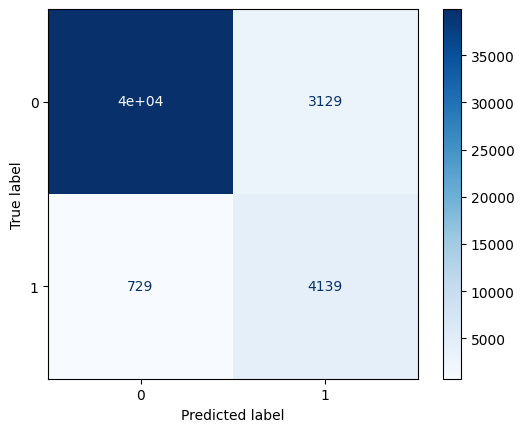

In [15]:
gs(feature='negative', pipe=tfidf_log_pipe, pipe_params=tfidf_log_params, filename='tfidf_log')

In [ ]:
# gs(feature='negative', pipe=cvec_svc_pipe, pipe_params=cvec_svc_params, filename='cvec_svc')

/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to 

KeyboardInterrupt: 

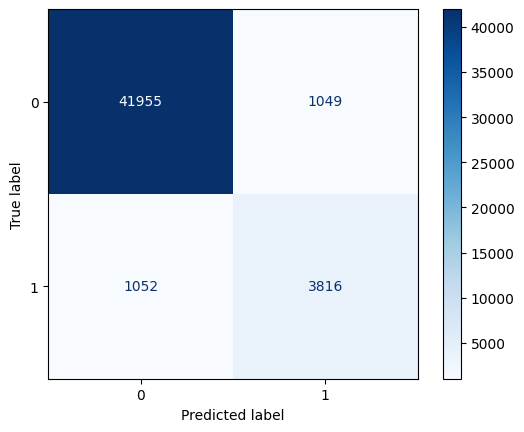

In [16]:
gs(feature='negative', pipe=tfidf_svc_pipe, pipe_params=tfidf_svc_params, filename='tfidf_svc')

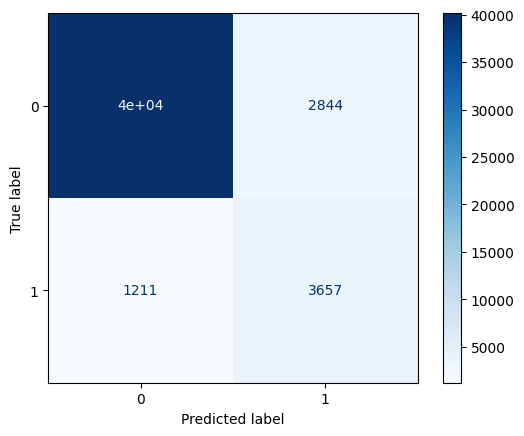

In [40]:
# gs(feature='negative', pipe=cvec_nb_pipe, pipe_params=cvec_nb_params, filename='cvec_nb')

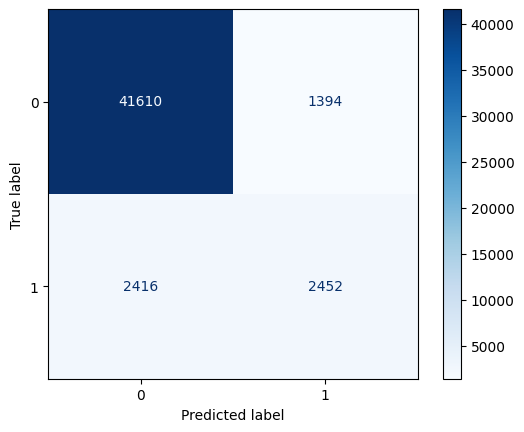

In [42]:
gs(feature='negative', pipe=tfidf_nb_pipe, pipe_params=tfidf_nb_params, filename='tfidf_nb')

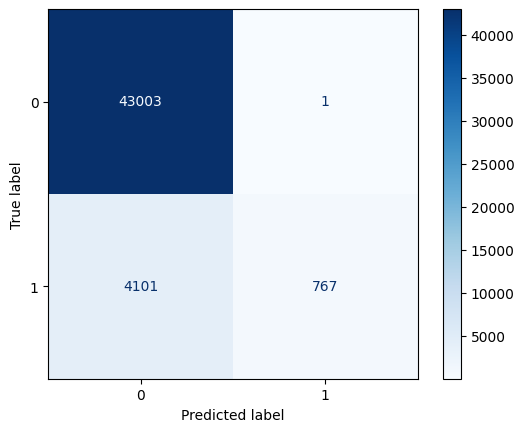

In [41]:
gs(feature='negative', pipe=tfidf_sgd_pipe, pipe_params=tfidf_sgd_params, filename='tfidf_sgd')

In [29]:
X = df_train_modified["cleaned_comment_text"]
y = df_train_modified['negative']

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [30]:
with open("../saved_file_transfer_model/cvec_log.pickle", "rb") as f:
    df = pickle.load(f)

f1_score(y_test, df.predict(X_test))

0.6494290375203915

In [31]:
with open("../saved_file_transfer_model/tfidf_log.pickle", "rb") as f:
    df = pickle.load(f)

f1_score(y_test, df.predict(X_test))

0.6625040544923775

In [32]:
with open("../saved_file_transfer_model/cvec_svc.pickle", "rb") as f:
    df = pickle.load(f)

f1_score(y_test, df.predict(X_test))

0.6471991445257876

In [55]:
with open("../saved_file_transfer_model/tfidf_svc.pickle", "rb") as f:
    df = pickle.load(f)

f1_score(y_test, df.predict(X_test))
# df.best_params_

0.7835836247685661

In [63]:
with open("../saved_file_transfer_model/tfidf_sgd.pickle", "rb") as f:
    df = pickle.load(f)

# f1_score(y_test, df.predict(X_test))
# accuracy_score(y_test,df.predict(X_test))
df.best_params_

{'sgd__alpha': 1,
 'sgd__class_weight': 'balanced',
 'sgd__max_iter': 10000,
 'sgd__penalty': 'l2',
 'tfidf__max_df': 0.95,
 'tfidf__max_features': 3000,
 'tfidf__min_df': 2,
 'tfidf__ngram_range': (1, 2)}

# SGD - explored

In [104]:
X = df_train_modified["cleaned_comment_text"]
y = df_train_modified['negative']

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [105]:
with open("../saved_file_transfer_model/tfidf_sgd.pickle", "rb") as f:
    sgd_model = pickle.load(f)

test_sgd_pred = sgd_model.predict(X_test)
train_sgd_pred = sgd_model.predict(X_train)

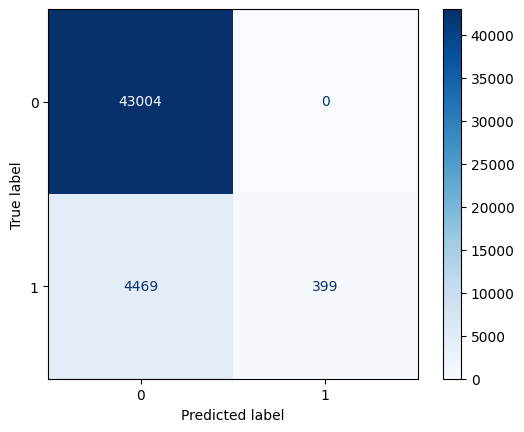

In [114]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, test_sgd_pred), display_labels=["0", "1"]
    ).plot(cmap="Blues")

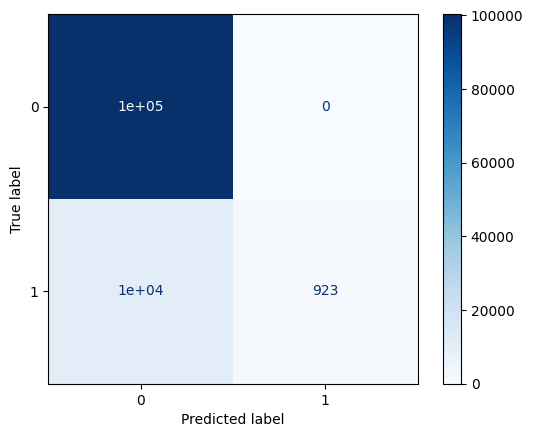

In [115]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_train, train_sgd_pred), display_labels=["0", "1"]
    ).plot(cmap="Blues")

In [109]:
# To select those comments that are predicted to be toxic
df_train_modified['negative_pred'] = sgd_model.predict(df_train_modified['cleaned_comment_text'])

In [113]:
df_train_modified['negative_pred'].value_counts()

0    158249
1      1322
Name: negative_pred, dtype: int64

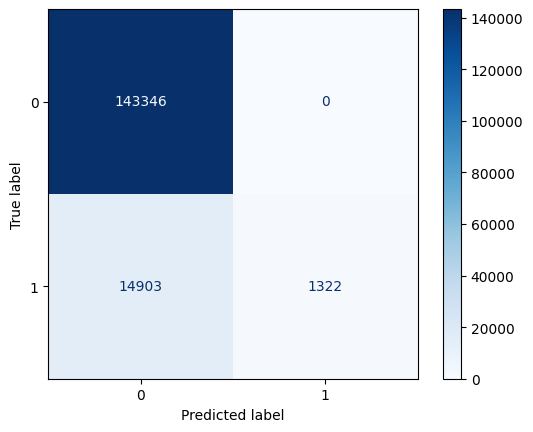

In [117]:
# Overall confusion matrix
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(df_train_modified['negative'], df_train_modified['negative_pred']), display_labels=["0", "1"]
    ).plot(cmap="Blues")

In [125]:
# Data has been cut - now to build the model on those that were identified to be negative

df_train_evolved = df_train_modified.copy().query("negative_pred == 1")
df_train_evolved.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,negative,cleaned_comment_text,negative_pred
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,1,fuck your filthy mother in the ass dry,1
181,006e87872c8b370c,you are a stupid fuck \n\nand your mother's cu...,1,1,1,0,1,0,1,you are a stupid fuck and your mother s cunt...,1
211,0086998b34865f93,"Fuck you, block me, you faggot pussy!",1,0,1,0,1,0,1,fuck you block me you faggot pussy,1
238,0097dd5c29bf7a15,u r a tw@ fuck off u gay boy.U r smelly.Fuck u...,1,0,1,0,1,1,1,you r a tw fuck off you gay boy you r smelly ...,1
312,00c59720428c985a,"""\n\n Fuck you \n\n Fuck you award go fuck yo...",1,0,1,0,1,0,1,fuck you fuck you award go fuck yourse...,1


In [126]:
df_train_evolved.shape

(1322, 11)

In [145]:
df_train_evolved['negative'].value_counts()

1    1322
Name: negative, dtype: int64

In [146]:
df_train_modified['negative'].value_counts()

0    143346
1     16225
Name: negative, dtype: int64

In [147]:
df_train_modified['negative_pred'].value_counts()

0    158249
1      1322
Name: negative_pred, dtype: int64

## Toxic - feature

In [133]:
X = df_train_evolved['cleaned_comment_text']
y = df_train_evolved['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [134]:
display(X_train.shape, X_test.shape)

(925,)

(397,)

In [138]:
y_train.value_counts()

1    925
Name: toxic, dtype: int64

In [136]:
# new func

def gs_evolved(feature, pipe, pipe_params, filename):

    X = df_train_evolved["cleaned_comment_text"]
    y = df_train_evolved[feature]

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, scoring="accuracy", n_jobs=-2)
    # gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, scoring="f1")

    gs.fit(X_train, y_train)

    with open(f"../saved_file_transfer_model/{filename}.pickle", "wb") as f:
        pickle.dump(gs, f)

    y_pred = gs.predict(X_test)

    # accuracy_score(y_test, y_pred)

    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=["0", "1"]
    ).plot(cmap="Blues")

In [137]:
gs_evolved(feature='toxic', pipe=tfidf_svc_pipe, pipe_params=tfidf_svc_params, filename='evolved_tfidf_svc')

ValueError: 
All the 216 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
216 fits failed with the following error:
Traceback (most recent call last):
  File "/home/bryan/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/bryan/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py", line 257, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "/home/bryan/.local/lib/python3.10/site-packages/sklearn/svm/_base.py", line 1162, in _fit_liblinear
    raise ValueError(
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1
